In [199]:
from skimage import io, exposure, measure
import pandas as pd
import numpy as np 
import os 
import glob 
import matplotlib.pyplot as plt
import re
import cv2
from pathlib import Path
from scipy.spatial.distance import cdist


In [200]:
# Get CSV for each timepoint/well
def main(well_csv_list, re_time, re_well,re_field, BF_path, output):
    for csv in well_csv_list:
        print(f'--current csv: {csv}--')

        # BF_file and Obj csv file located in different dir; use csv to match each obj to correct BF_image 
        df = pd.read_csv(csv); BF_files = df.iloc[:, df.columns.get_loc('FileName_BF')]

        # For each csv (timepoint/well) split csv into different FOV (1-9)
        # Reset field number for each csv file i.e. well
        for f, field in enumerate(pd.unique(BF_files)): 
            
            # Locate correct BF_image using metadata extracted from csv file
            time = re_time.findall(str(field))[0]; well = re_well.findall(str(field))[0]; field_re=re_field.findall(str(field))[0]
            BF_file = f'{BF_path}/{time}/{well}/Brightfield/{field}'

            # Split df on FOV; get centre coordinates for each obj
            df_field = df[df['FileName_BF'].isin([field])]
            
            # Get Image masks for every FOV in Well
            field_f = field_re.replace('_', '') 
            
            print(len(df_field))
            # Centre crop all objects & Save to new CentreCrops/Timepoint/Well/*
            output_dir = os.path.join(output, time, well)

            for obj in range(0,len(df_field)):
                print(obj)
                
                img_list=glob.glob(f'/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/{time}/{well}/{field_f}/*.tiff')
                img_masks = io.imread(img_list[0])
                
                print('----------innner for loop -----------------------')
                obj_filename = f'{time}_{well}_Field_{f+1}_obj{obj}.tif'
                cropped_img = get_centre_crop(df_field, BF_file, obj, img_masks)
                save_crop(obj_filename, cropped_img, output_dir)
        
            # Update field number 
            print(f'outer -----------Object: {obj} for field: {field} {f+1}successfully cropped-----------')
                
    return 0

In [201]:
# Centre Crop Cells
def crop_img_test(df, img, obj_number):

    # Get Coordinates
    centre_X = int(df.iloc[obj_number, df.columns.get_loc('Location_Center_X')])
    centre_Y = int(df.iloc[obj_number, df.columns.get_loc('Location_Center_Y')])
    
    # Crop using centre
    y2, y1, x2, x1 = int(centre_Y+100), int(centre_Y-100),  int(centre_X+100), int(centre_X-100)
    cropped = img[y1:y2, x1:x2]
    
    return cropped

In [202]:
# Save Image to timepoint/well dir
def save_crop(file, img, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    grayscale_stack = np.dstack([img, img, img])
    io.imsave(os.path.join(output_dir, file), grayscale_stack)
    print('saving image')
    
    return 0

In [219]:
def get_blurred_mask(df, BF_file, obj_number, mask): 
    BF_img = io.imread(BF_file).astype('float')/255
    mask = io.imread(mask)

    print('------------get centre crop--------------------')
    mask_blurred  = cv2.GaussianBlur(mask,(3,3),0)
    mask_large=np.where(mask_blurred>0, BF_img, 1)
    mask_large_blurred = cv2.GaussianBlur(mask_large, (11,11),0)
    img=mask_large_blurred.astype('float')/255
    img=((img*BF_img)*255).astype('uint16')
    plt.imshow(img)
    return (crop_img_test(df, img, obj_number))


In [204]:
filepath = '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_1.tiff'

In [262]:
test1 = '/hpc/scratch/hdd2/fs541623/test1/FiltereredCytObjects_1.tiff'

In [206]:
BF_file = '/hpc/scratch/hdd2/fs541623/Pre_processed_Images/Time_16hrs_R1/Well_08/Brightfield/Time_16hrs_R1_Well_08_Field_1_C1.tif'

In [207]:
masks_f = glob.glob('/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/*.tiff') 

In [208]:
masks_f.sort(key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

In [209]:
centre_X = int(df.iloc[0, df.columns.get_loc('Location_Center_X')])
centre_Y = int(df.iloc[0, df.columns.get_loc('Location_Center_Y')])
centre_X, centre_Y

(963, 107)

In [255]:
np.unique(io.imread(filepath))

array([  0, 255], dtype=uint8)

In [263]:
props = measure.regionprops_table(measure.label(io.imread(test1)), properties=['centroid'])

In [264]:
props

{'centroid-0': array([107.3583043]), 'centroid-1': array([963.18815331])}

In [251]:
data = pd.DataFrame([])
for mask in masks_f:
    mask = io.imread(mask)
    props = measure.regionprops_table(mask, properties=['centroid'], coordinates=coordinates)
    data = data.append(pd.DataFrame(props, index=[0]), ignore_index=True)    

NameError: name 'coordinates' is not defined

In [212]:
# Centroid-0 = Location_center_Y, centroid-1 = location_center_X 
# 963.1881533	107.3583043
# 779.9942993	121.792399
# Get filename from savecroppedobjectts that corresponds to CP_Data
data['distance'] =  np.linalg.norm(data[['centroid-0', 'centroid-1']].sub(np.array([121.792399, 779.9942993])), axis=1)

In [213]:
data.iloc[data['distance'].abs().idxmin()].to_string()

'centroid-0    141.020548\ncentroid-1    772.993151\ndistance       20.463084'

In [214]:
# Get cell mask of corresponding filename from savecroppedobjects 
mask_file = data.iloc[data['distance'].abs().idxmin()]['Filename']; mask_file

KeyError: 'Filename'

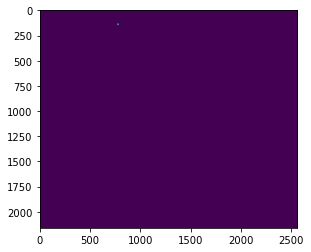

In [100]:
mask = io.imread(mask_file); plt.imshow(mask)

------------get centre crop--------------------


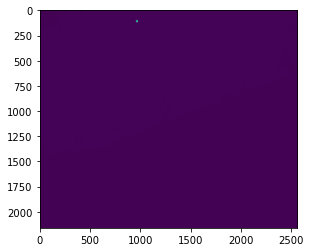

In [221]:
## pass in object number from CP_data df
masked = (get_blurred_mask(df_field, BF_file, 0, filepath)); 


In [243]:
data['Filename'] = masks_f

In [245]:
data.to_string()

'      centroid-0   centroid-1                                                                                                                        Filename\n0     110.061905   961.876190    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_1.tiff\n1     115.588710  2058.052419    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_2.tiff\n2     118.004032  2089.439516    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_3.tiff\n3     121.474576  2251.847458    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_4.tiff\n4     125.915344  1125.338624    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_5.tiff\n5     129.398649  1444.864865    /hpc/scratch

In [223]:
masks_f

['/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_1.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_2.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_3.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_4.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_5.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_6.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_7.tiff',
 '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08

In [216]:
## CSV to join
csv = '/hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Data/Time_16hrs_R1/Well_08/FilteredCytObj.csv'
df = pd.read_csv(csv)

In [217]:
df_field = df[df['FileName_BF'].isin(['Time_16hrs_R1_Well_08_Field_1_C1.tif'])]; df_field

,ImageNumber,ObjectNumber,Metadata_Channel,Metadata_Field,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_Time,Metadata_Well,Metadata_Well.1,...,Texture_Variance_Cyt_Crop_3_02_256,Texture_Variance_Cyt_Crop_3_03_256,Texture_Variance_Nuc_Crop_3_00_256,Texture_Variance_Nuc_Crop_3_01_256,Texture_Variance_Nuc_Crop_3_02_256,Texture_Variance_Nuc_Crop_3_03_256,Texture_Variance_PI_Crop_3_00_256,Texture_Variance_PI_Crop_3_01_256,Texture_Variance_PI_Crop_3_02_256,Texture_Variance_PI_Crop_3_03_256
0,1,1,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,160.443055,160.262432,0.005576,0.006787,0.00666,0.00666,0.040557,0.042483,0.042963,0.041080
1,1,2,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.013675,0.014126,0.013252,0.014305
2,1,3,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.067175,0.068245,0.066766,0.068782
3,1,4,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.168111,0.166436,0.162971,0.181773
4,1,5,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,51.093019,54.373408,0.000000,0.000000,0.00000,0.00000,0.128372,0.122676,0.129686,0.131189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,1,625,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
625,1,626,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
626,1,627,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
627,1,628,NaN,NaN,NaN,0,0,16hrs_R1,8,8,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000


In [ ]:
data.merge(df_field, left_on=)

In [218]:
print(data.to_string())

      centroid-0   centroid-1     distance                                                                                                                        Filename
0     110.061905   961.876190   182.259778    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_1.tiff
1     115.588710  2058.052419  1278.073176    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_2.tiff
2     118.004032  2089.439516  1309.450697    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_3.tiff
3     121.474576  2251.847458  1471.853193    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Field1/FilteredCytObj_4.tiff
4     125.915344  1125.338624   345.368935    /hpc/scratch/hdd2/fs541623/CellProfilerFeatureExtraction/CP_Cropped_Cells/Time_16hrs_R1/Well_08/Fie